# Bootstrapping

Bootstrapping at its most basic seeks to understand the finite sample properties of an estimator by repeatedly creating finite samples from the data you have, estimating what you want to estimate, and examining the distribution of that estimator. Perhaps the most intuitive way to bootstrap is the empirical bootstrap, which literally implements what I just described. 

But by doing this we're suggesting something about what we think is random about the regression, mainly, that the $X$ are random. That is, the distribution of our random variable $\beta$ comes from sampling variation in the covariates. But this framework doesn't make a whole lot of sense when our covariates are not random. For example, if we run an experiment and assign a treatment vector to our sample, then our covariates are fixed within our sample. Likewise, we might think of a respondent's sex as fixed$^*$ and not something that makes sense to be shuffling around. But what else might be random in the regression?

Well, maybe our distrubances are random. That is, there might be random shocks in the other determinants of $y$. This motivates the residual bootstrap.

I like [this resource](https://www.sagepub.com/sites/default/files/upm-binaries/21122_Chapter_21.pdf) for better understanding the bootstrap.

## The residual bootstrap
Consider a an empirical setting where we want to estimate the gender wage gap, and we have information on workers $i$ and their wages and sex. Our estimating equation is:

$$w_{i} = \alpha + \tau Female_{i} + \varepsilon_{i}$$

The idea for the residual bootstrap is to:

1. Run OLS $w_{i} = \alpha + \tau Female_{i} + e_{i}$
2. Calculate errors $e'= w_i - \widehat{\tau}Female_{i} - \widehat{\alpha}$
3. Resample from the vector of errors $e'$ to get a new vector of errors $\tilde{e'}$
4. Construct $y'_i = \widehat{\alpha} + \widehat{\tau}Female_{i} + \tilde{e'}_i$
5. Repeat.

### A note on identification

There is nothing causal in the above model, but suppose you were doing this for a causal model, and that your regression suffers from omitted variables bias such that the model will yield a $\widehat{\tau}$ such that $E(\widehat{\tau})\neq \tau$. Why is it still okay to resample the residuals?

Because of the properties of agnostic regression! Even if $E(X\varepsilon)\neq0$, OLS mechanically makes sure that the prediction error is uncorrelated with the regressors. So bias does _not_ imply that our observed errors are correlated with X.


# Linear approximations

Implicit code review of: [linear-non-linear.ipynb](https://github.com/ligonteaching/ARE212_Materials/blob/master/linear-non-linear.ipynb)

We know that regression is the best linear approximator of the potentially non-linear conditional expectation function, $E(y|X)$. Linear regression is linear in _parameters_, but we can combine non-linear transformations of the explanatory variables to predict some pretty non-linear stuff! For example, the function $y = a + bx + cx^2$ is linear in $(a, b, c)$, but the linear combination of terms clearly returns something very non-linear.

Sticking with the polynomial case, by adding more and more terms we can approximate arbitrarily complex non-linear functions. But how do we know what the $(a, b, c, \ldots)$ should be? Easy: regression. We just create a regression function with $K$ covariates, which are $(1, x, x^2, x^3, \ldots, x^K)$, and estimate the $\beta$'s for each one.

First, let's create a non-linear function we want to approximate.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def trueFunc(x):
    y = np.sin(x**2-2) + 1
    return y

Text(0.5, 1.0, 'True function F on [0,3]')

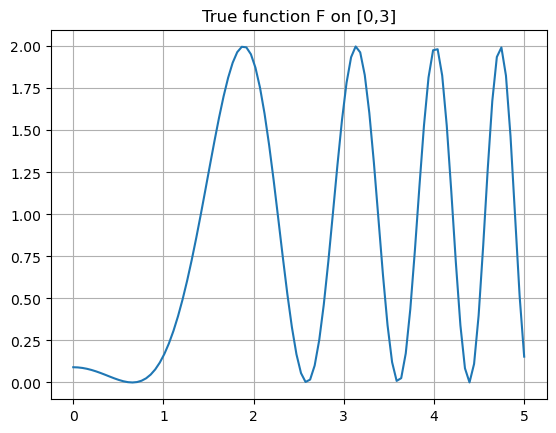

In [3]:
domain = np.linspace(0, 5, 100)

fig, ax = plt.subplots()
plt.plot(domain, [trueFunc(x) for x in domain])

plt.grid()
plt.title("True function F on [0,3]")

In data we might think that we observe draws of X and y from this true function, but there is also noise in the data. So let's simulate that.

In [4]:
def noisyData_DGP(N, f, domain, std_errors=0.3):
    # pass in f, and domain to make as general as possible
    # domain should take the form (minim, maxim)
    X = np.linspace(domain[0], domain[1], N)
    y = [f(x) for x in X] + np.random.normal(scale=std_errors, size = N)
    
    return (X.reshape((-1,1)), y.reshape((-1,1)))  

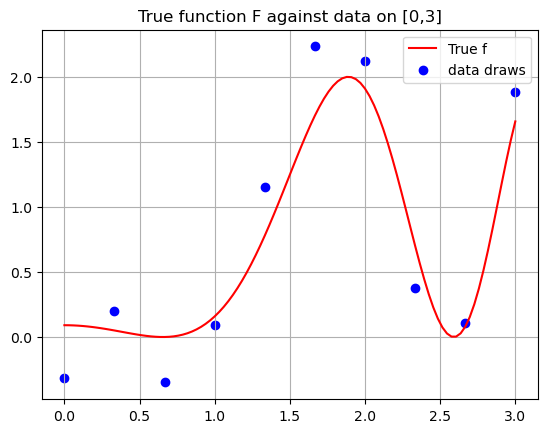

In [5]:
minn = 0
maxx = 3
N = 10

data = np.linspace(minn, maxx, 100)
sim_data = noisyData_DGP(N, trueFunc, (minn, maxx))

fig, ax = plt.subplots()
plt.plot(data, [trueFunc(x) for x in data], color = 'red', label = 'True f')
plt.scatter(sim_data[0], sim_data[1], color = 'blue', label = 'data draws')

plt.grid()
plt.title("True function F against data on [0,3]")
plt.legend()

## Polynomial approximation

Now we're going to see how well we can approximate this function with different numbers of polynomials, K. Note that K=1 will have 2 terms, an intercept and x. Our steps are:

1. Given a data vector X, create our set of polynomials [X^0, X^1, ..., X^K]
2. With our polynomial dataset, estimate coefficients via linear regression:

$$y_i = \sum_{k=0}^{K-1} a_kx_i^k + e_i$$

3. Predict $\widehat{y}(x)$ for the $x$ of interest given $\{\widehat{a}_k\}$

### Step 1: Make polynomials

In [6]:
def makePoly(x, K):
    '''
    Given a numpy array x (Nx1), create an array Nx(K+1) of polynomials [X^0, X^1, ..., X^K]
    '''
    Xvec = np.concatenate([x**k for k in range(K)], axis = 1)
    return Xvec

# test
makePoly(sim_data[0], 1)    

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]])

### Steps 1-3 together

In [7]:
def fhat_polynomial(x, data, K):
    # first make the polynomials
    X, y = data
    # make polynomials
    Xvec = makePoly(X, K)  
    # regress!
    betas = np.linalg.lstsq(Xvec, y, rcond=None)[0]
    # make polynomials for our new X
    Xvec_pred = makePoly(x, K)
    
    # predict
    yhat = Xvec_pred@betas
    return yhat

(-0.5, 3.0)

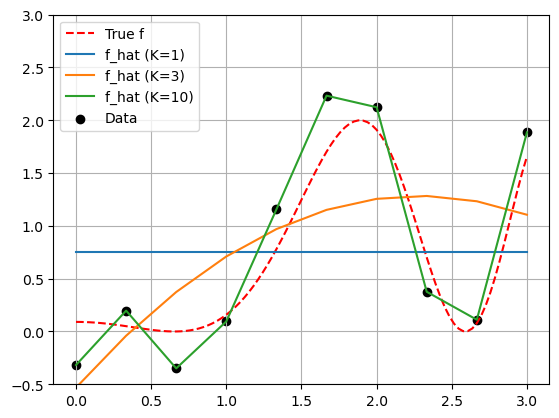

In [8]:
fig, ax = plt.subplots()

plt.plot(data, [trueFunc(x) for x in data], color = 'red', label = 'True f', linestyle = '--')
plt.scatter(sim_data[0], sim_data[1], color = 'black', label = 'Data')

for k in [1, 3, 10]:
    plt.plot(sim_data[0], 
             fhat_polynomial(sim_data[0], sim_data, K=k),
             label = f'f_hat (K={k})')

plt.grid()
plt.legend(loc='upper left')
ax.set_ylim([-0.5, 3])

The above graph really only interpolates a line between our yhats. So to get a better sense of what these functions look like, I am going to plot a bunch of yhats for new data between min - 1 and max + 1.

(-3.0, 5.0)

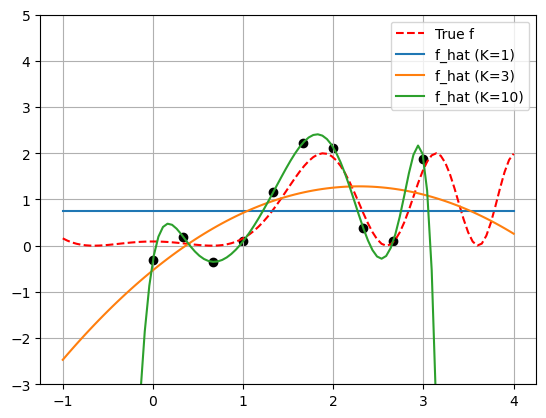

In [9]:
fig, ax = plt.subplots()

plotdata = np.linspace(minn - 1, maxx + 1, 100).reshape((-1,1))

plt.plot(plotdata, [trueFunc(x) for x in plotdata], color = 'red', label = 'True f', linestyle = '--')
plt.scatter(sim_data[0], sim_data[1], color = 'black')

for k in [1, 3, 10]:
    plt.plot(plotdata, 
             fhat_polynomial(plotdata, sim_data, K=k),
             label = f'f_hat (K={k})')

plt.grid()
plt.legend()
ax.set_ylim([-3, 5])

### There's a lot to dislike about this graph.

1. The green line hits every single data point. This is because with K = N approximating functions, we can exactly fit the data by solving the linear system of equations. But out goal is not to exactly fit the data, because we know that the data is partially noise. So we are literally fitting noise. This is the problem of **overfitting** in machine learning- if we are overly good at matching the idiosyncratic noise in our current data, extrapolating to new data may not work well because the noise in new observations is inherently different. 
2. The tails are very poorly behaved. This is known as Runge's phenomenon- high order polynomials will have insane peaks (like between the last two data points) and the ends may go off to inifinity since there is no more data there to discipline the function.

## Choosing between polynomials
So what might be a sensible way to choose what $K$ should be? There are several candidate metrics, but what are we interested in?

1. Overfitting - Overfitting means that we have done too well estimating the expected value of our data, but the concern is that given new data we wouldn't do well at predicting. What kind of test would we want to tell us how big a problem this might be?
2. Underfitting - We're not even good at predicting the data we already have. What kind of metric would be informative for telling us how well we're capturing $E(y|X)$?